# ============================================================
# ADVANCED CUSTOMER SEGMENTATION — COMPLETE ANALYSIS
# Online Retail Dataset (UCI ML Repository)
# Author: Sumit Prajapat | Portfolio Project 2026
# ============================================================



# # 🛒 Advanced Customer Segmentation with Machine Learning
#
# ## Business Context
# A UK-based online retailer wants to understand their customer base better.
# Instead of treating all customers the same, we will identify **distinct behavioral segments**
# and design **targeted marketing strategies** for each group.
#
# ### Why Customer Segmentation?
# - 20% of customers typically generate 80% of revenue (Pareto Principle)
# - Generic mass marketing = wasted budget
# - Segmented campaigns have **14x higher click-through rates** and **10x conversion uplift**
# - Enables personalized retention strategies before customers churn
#
# ### Project Objectives
# 1. Calculate RFM (Recency, Frequency, Monetary) metrics per customer
# 2. Apply business-rule-based segmentation (RFM scoring)
# 3. Apply ML clustering (K-Means, Hierarchical, DBSCAN)
# 4. Compare methods and extract actionable business insights
# 5. Build a production-ready segmentation pipeline


# ---
# ## PART 1: Setup & Data Loading
# **Dataset**: Online Retail (UCI ML Repository)
# - 541,909 transactions from Dec 2010 – Dec 2011
# - UK-based non-store online retail
# - Products: mainly unique all-occasion gifts
# - Many customers are wholesalers
#
# **Download Instructions**:
# 1. Go to: https://archive.ics.uci.edu/ml/datasets/Online+Retail
# 2. Click "Download" → get `Online Retail.xlsx`
# 3. Place file in `data/online_retail.xlsx`
# OR run the download code below (requires `requests` package)

In [2]:
# ── Imports ────────────────────────────────────────────────────────────────────
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.dpi': 120, 'font.family': 'DejaVu Sans', 'axes.spines.top': False,
                     'axes.spines.right': False})

# Add project root to path
sys.path.insert(0, os.path.abspath('..'))
print("✅ All imports successful")
print(f"NumPy: {np.__version__} | Pandas: {pd.__version__}")


✅ All imports successful
NumPy: 2.4.2 | Pandas: 2.3.3


# ── Load Data ──────────────────────────────────────────────────────────────────
# Option A: Excel (recommended — official UCI file)
# df_raw = pd.read_excel('../data/online_retail.xlsx', engine='openpyxl')

# Option B: CSV (if you converted it)
# df_raw = pd.read_csv('../data/online_retail.csv', encoding='ISO-8859-1')


In [3]:
np.random.seed(42)

In [4]:

def generate_synthetic_retail(n_customers=4000, n_transactions=50000):
    """Generate synthetic data matching UCI Online Retail schema for demo/testing."""
    customer_ids = np.random.randint(12000, 18000, n_customers)
    dates = pd.date_range('2010-12-01', '2011-12-09', freq='D')

    records = []
    for _ in range(n_transactions):
        cid = np.random.choice(customer_ids)
        date = np.random.choice(dates)
        qty = np.random.choice([1, 2, 3, 6, 12], p=[0.5, 0.2, 0.15, 0.1, 0.05])
        price = round(np.random.lognormal(1.5, 0.8), 2)
        records.append({
            'InvoiceNo': f'5{np.random.randint(10000, 99999)}',
            'StockCode': f'{np.random.randint(10000, 99999)}',
            'Description': 'Sample Product',
            'Quantity': qty,
            'InvoiceDate': date,
            'UnitPrice': price,
            'CustomerID': float(cid),
            'Country': 'United Kingdom'
        })

    df = pd.DataFrame(records)
    # Add ~5% cancellations
    cancel_idx = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
    df.loc[cancel_idx, 'InvoiceNo'] = 'C' + df.loc[cancel_idx, 'InvoiceNo']
    df.loc[cancel_idx, 'Quantity'] = -df.loc[cancel_idx, 'Quantity']
    # Add ~10% missing CustomerIDs
    missing_idx = np.random.choice(df.index, size=int(0.10 * len(df)), replace=False)
    df.loc[missing_idx, 'CustomerID'] = np.nan
    return df

df_raw = generate_synthetic_retail()
print(f"📦 Dataset loaded: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print("\n🗂️  Columns:", df_raw.columns.tolist())
df_raw.head()

📦 Dataset loaded: 50,000 rows × 8 columns

🗂️  Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,589303,21308,Sample Product,2,2011-12-08,7.66,NaN,United Kingdom
1,512204,97265,Sample Product,1,2011-01-28,7.70,17374.0,United Kingdom
2,531607,34968,Sample Product,3,2011-06-23,2.57,12261.0,United Kingdom
3,584707,88257,Sample Product,2,2011-04-12,4.34,12732.0,United Kingdom
4,556169,17659,Sample Product,2,2011-04-22,2.62,17823.0,United Kingdom


# ## PART 2: Data Quality Report & EDA

# ── Data Quality Report -

DATA QUALITY REPORT
                      dtype  null_count  null_pct  unique_count
InvoiceNo            object           0       0.0         39349
StockCode            object           0       0.0         38280
Description          object           0       0.0             1
Quantity              int64           0       0.0            10
InvoiceDate  datetime64[ns]           0       0.0           374
UnitPrice           float64           0       0.0          3010
CustomerID          float64        5000      10.0          2872
Country              object           0       0.0             1

📊 Statistical Summary:
       Quantity  UnitPrice
count  50000.00   50000.00
mean       2.28       6.19
std        2.82       5.90
min      -12.00       0.13
25%        1.00       2.60
50%        1.00       4.49
75%        3.00       7.67
max       12.00     134.65


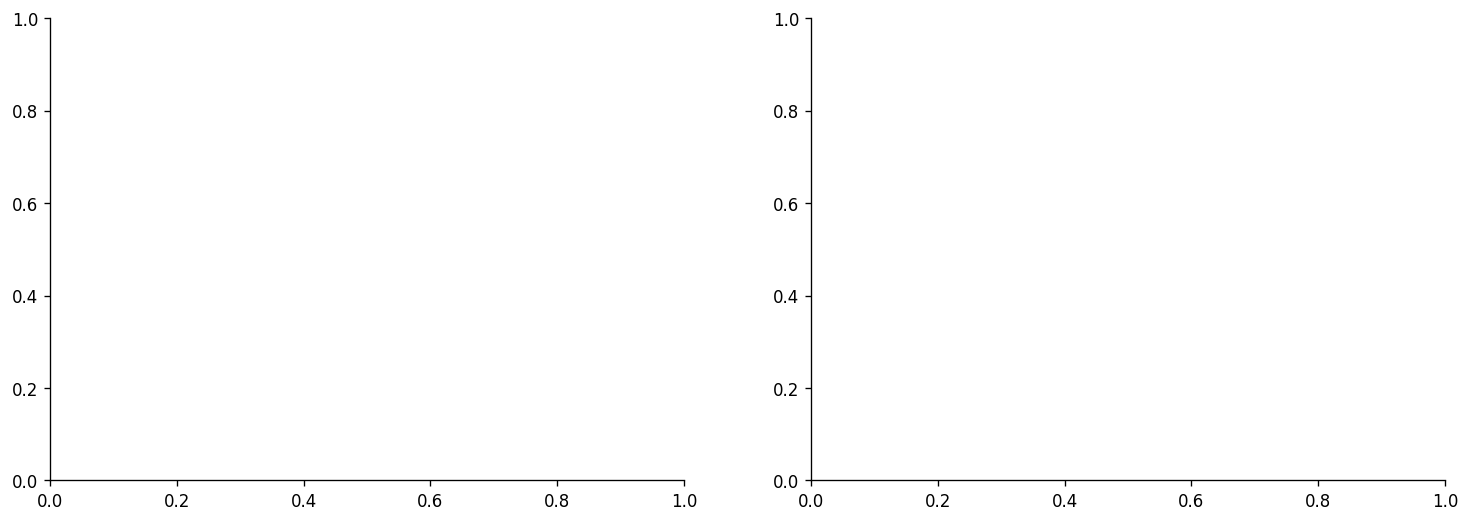

In [11]:

print("=" * 60)
print("DATA QUALITY REPORT")
print("=" * 60)
quality_report = pd.DataFrame({
    'dtype': df_raw.dtypes,
    'null_count': df_raw.isnull().sum(),
    'null_pct': (df_raw.isnull().sum() / len(df_raw) * 100).round(2),
    'unique_count': df_raw.nunique(),
})
print(quality_report.to_string())

# %%
print(f"\n📊 Statistical Summary:")
print(df_raw[['Quantity', 'UnitPrice']].describe().round(2))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ── EDA: Country Distribution

In [ ]:
# Transactions by country (top 10)
country_counts = df_raw['Country'].value_counts().head(10)
axes[0].barh(country_counts.index, country_counts.values,
             color=sns.color_palette('Blues_d', 10))
axes[0].set_title('Top 10 Countries by Transactions', fontweight='bold')
axes[0].set_xlabel('Transaction Count')
axes[0].invert_yaxis()

# Transactions over time
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])
monthly = df_raw.groupby(df_raw['InvoiceDate'].dt.to_period('M')).size()
axes[1].plot(monthly.index.astype(str), monthly.values, 'o-',
             color='steelblue', linewidth=2, markersize=6)
axes[1].set_title('Monthly Transaction Volume', fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Transactions')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/eda_overview.png', bbox_inches='tight')
plt.show()


# ## PART 3: Data Cleaning

In [12]:

# ── Clean Data ─────────────────────────────────────────────────────────────────
df = df_raw.copy()
original_size = len(df)


In [13]:

# 1. Parse dates
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [14]:

# 2. Drop missing CustomerID
df = df.dropna(subset=['CustomerID'])
print(f"After dropping missing CustomerID: {len(df):,} rows (removed {original_size - len(df):,})")


After dropping missing CustomerID: 45,000 rows (removed 5,000)


In [15]:

# 3. Remove cancellations
before = len(df)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print(f"After removing cancellations: {len(df):,} rows (removed {before - len(df):,})")


After removing cancellations: 42,747 rows (removed 2,253)


In [16]:

# 4. Remove invalid Quantity/UnitPrice
before = len(df)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"After removing invalid Q/P: {len(df):,} rows (removed {before - len(df):,})")


After removing invalid Q/P: 42,747 rows (removed 0)


In [17]:

# 5. Add TotalAmount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

print(f"\n✅ Final clean dataset: {df.shape[0]:,} rows")
print(f"📅 Date range: {df['InvoiceDate'].min().date()} → {df['InvoiceDate'].max().date()}")
print(f"👥 Unique customers: {df['CustomerID'].nunique():,}")
print(f"🧾 Unique invoices:  {df['InvoiceNo'].nunique():,}")
print(f"💷 Total revenue:    £{df['TotalAmount'].sum():,.0f}")



✅ Final clean dataset: 42,747 rows
📅 Date range: 2010-12-01 → 2011-12-09
👥 Unique customers: 2,872
🧾 Unique invoices:  34,001
💷 Total revenue:    £670,046


# PART 4: RFM Feature Engineering

In [18]:
# ── Calculate RFM ──────────────────────────────────────────────────────────────
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"📅 Analysis snapshot date: {snapshot_date.date()}")

rfm = df.groupby('CustomerID').agg(
    Recency   = ('InvoiceDate',  lambda x: (snapshot_date - x.max()).days),
    Frequency = ('InvoiceNo',    'nunique'),
    Monetary  = ('TotalAmount',  'sum')
).reset_index()


📅 Analysis snapshot date: 2011-12-10


In [19]:

# Round monetary to 2dp
rfm['Monetary'] = rfm['Monetary'].round(2)

print(f"\n📊 RFM Summary:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe().round(2).to_string())




📊 RFM Summary:
       Recency  Frequency  Monetary
count  2872.00    2872.00   2872.00
mean     29.73      14.88    233.30
std      31.65       8.15    165.70
min       1.00       1.00      4.61
25%       8.00       9.00    114.66
50%      19.00      12.00    187.10
75%      40.00      18.00    304.37
max     322.00      70.00   1407.36


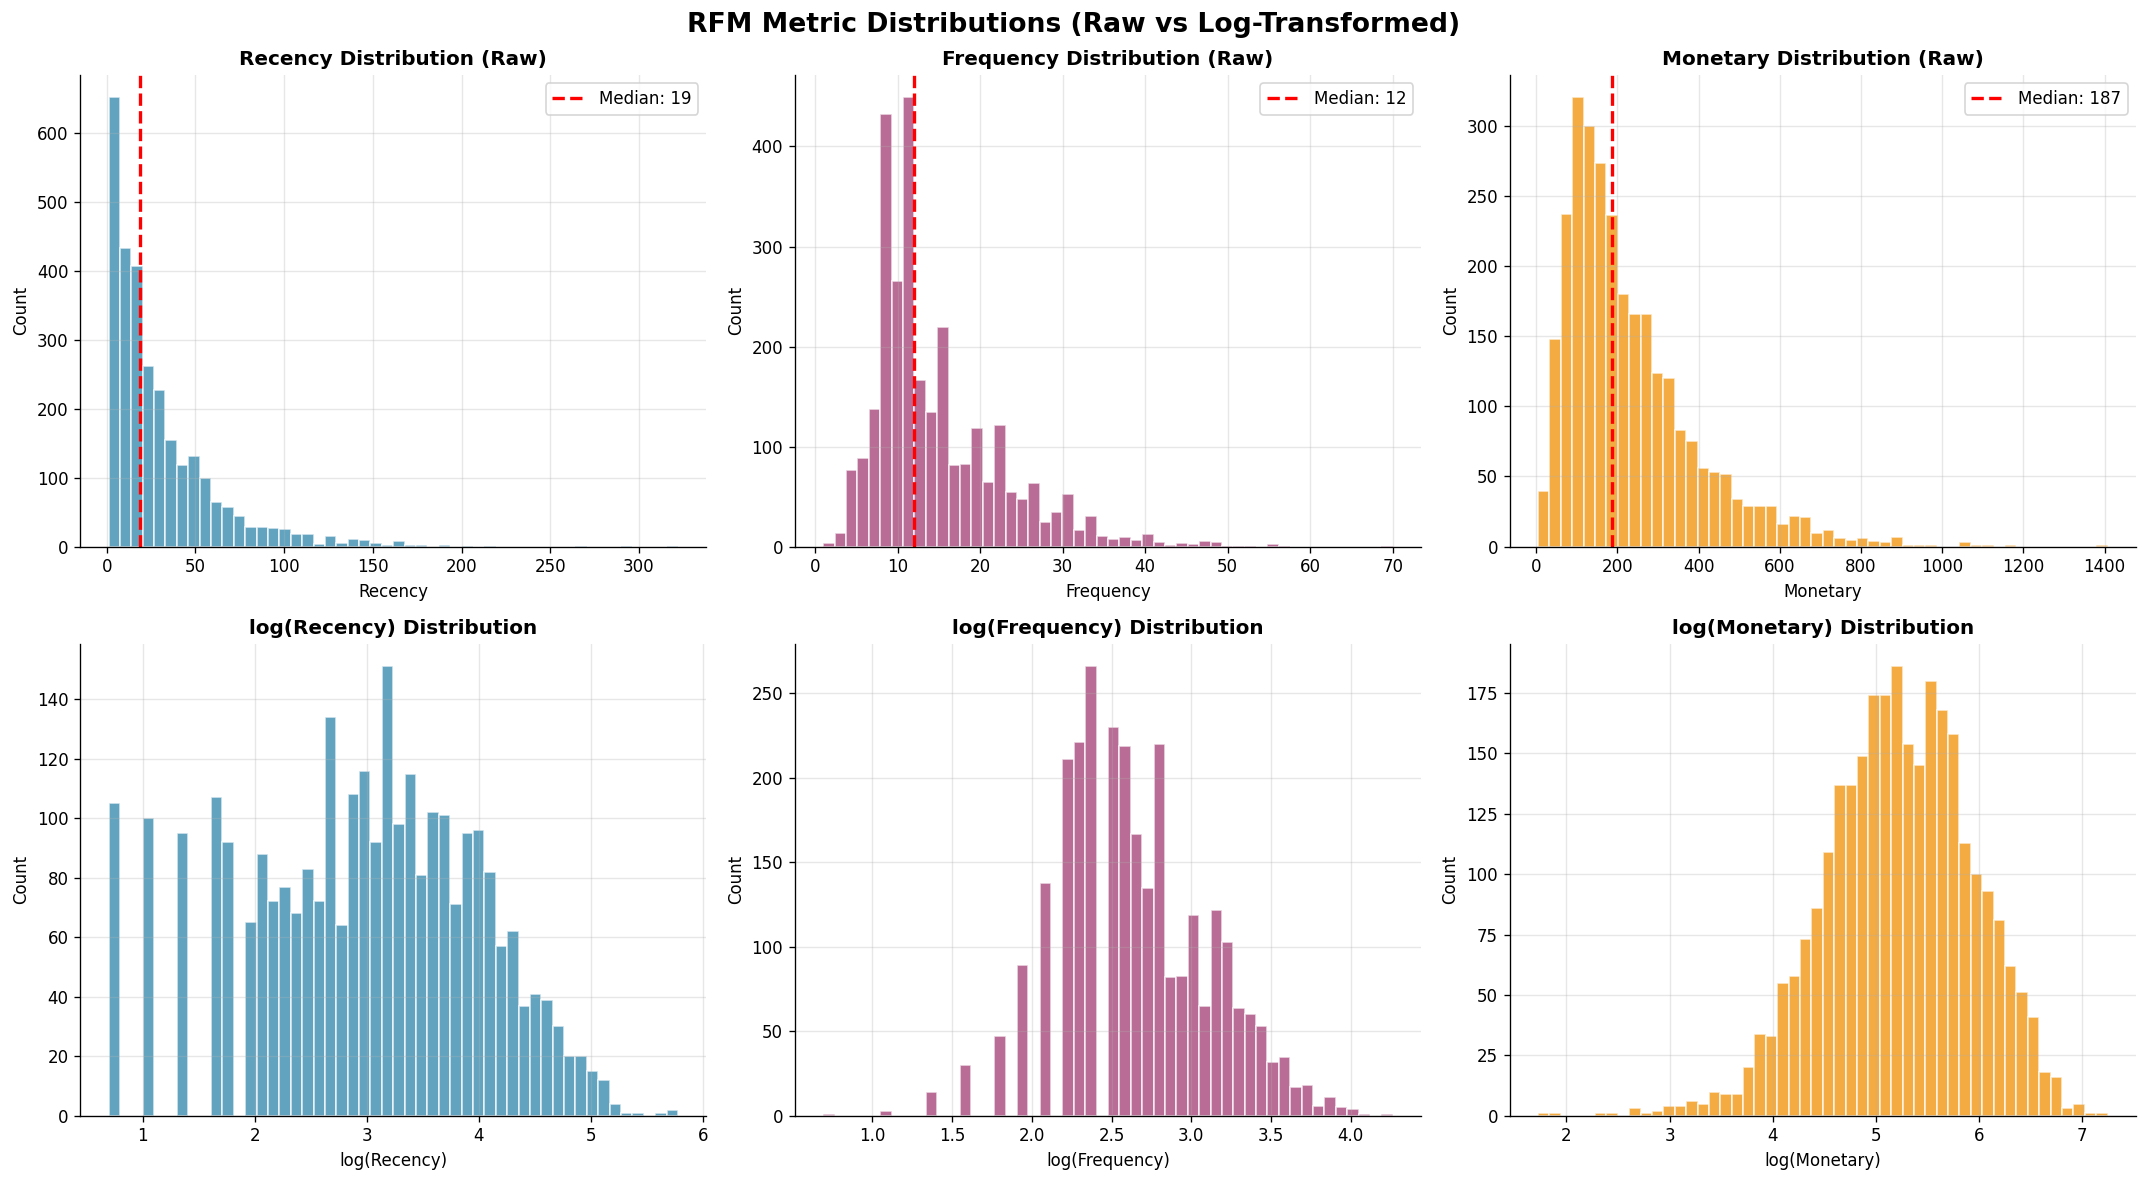

In [20]:

# ── RFM Distribution Plots ─────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Recency', 'Frequency', 'Monetary']
colors = ['#2E86AB', '#A23B72', '#F18F01']

for i, (col, color) in enumerate(zip(metrics, colors)):
    # Raw histogram
    ax = axes[0][i]
    ax.hist(rfm[col], bins=50, color=color, alpha=0.75, edgecolor='white')
    ax.axvline(rfm[col].median(), color='red', linestyle='--', linewidth=2,
               label=f'Median: {rfm[col].median():.0f}')
    ax.set_title(f'{col} Distribution (Raw)', fontweight='bold', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Log-transformed
    ax = axes[1][i]
    log_data = np.log1p(rfm[col])
    ax.hist(log_data, bins=50, color=color, alpha=0.75, edgecolor='white')
    ax.set_title(f'log({col}) Distribution', fontweight='bold', fontsize=12)
    ax.set_xlabel(f'log({col})')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

plt.suptitle('RFM Metric Distributions (Raw vs Log-Transformed)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/rfm_distributions.png', bbox_inches='tight')
plt.show()


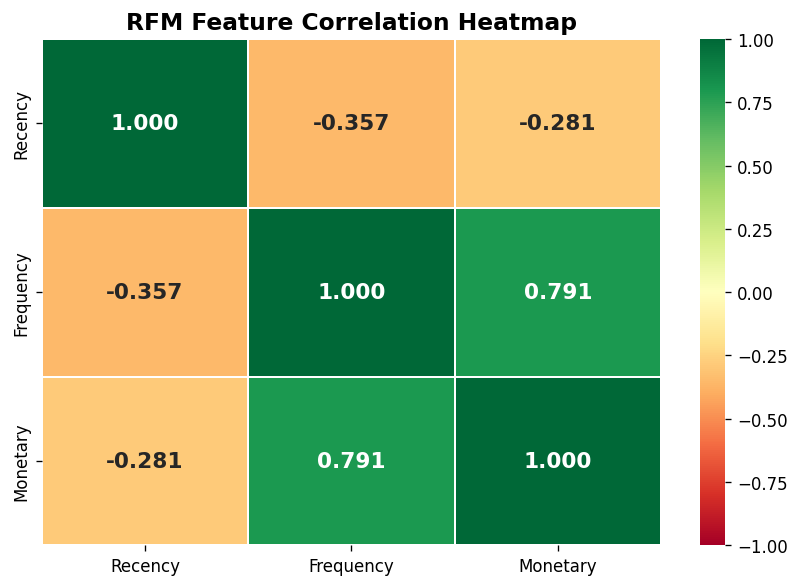

In [21]:
# ── Correlation Heatmap ────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 5))
corr = rfm[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(corr, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0, vmin=-1, vmax=1, ax=ax, linewidths=1,
            annot_kws={'size': 13, 'weight': 'bold'})
ax.set_title('RFM Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/correlation_heatmap.png', bbox_inches='tight')
plt.show()

# PART 5: RFM Scoring & Business Segmentation

In [22]:
# ── RFM Scoring (1-5 scale) ────────────────────────────────────────────────────
rfm_scored = rfm.copy()

# Recency: lower days = better = higher score (INVERSE)
rfm_scored['R_Score'] = pd.qcut(rfm_scored['Recency'],
                                  q=5, labels=[5, 4, 3, 2, 1], duplicates='drop').astype(int)
# Frequency: higher = better
rfm_scored['F_Score'] = pd.qcut(rfm_scored['Frequency'].rank(method='first'),
                                  q=5, labels=[1, 2, 3, 4, 5]).astype(int)
# Monetary: higher = better
rfm_scored['M_Score'] = pd.qcut(rfm_scored['Monetary'].rank(method='first'),
                                  q=5, labels=[1, 2, 3, 4, 5]).astype(int)

rfm_scored['RFM_Score']  = rfm_scored['R_Score'].astype(str) + rfm_scored['F_Score'].astype(str) + rfm_scored['M_Score'].astype(str)
rfm_scored['RFM_Total']  = rfm_scored['R_Score'] + rfm_scored['F_Score'] + rfm_scored['M_Score']

print("✅ RFM Scores calculated")
print(rfm_scored[['CustomerID', 'Recency', 'Frequency', 'Monetary',
                   'R_Score', 'F_Score', 'M_Score', 'RFM_Total']].head(10).to_string(index=False))


✅ RFM Scores calculated
CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  RFM_Total
     12001        1         25    333.26        5        5        4         14
     12002        1          8     65.19        5        1        1          7
     12003        4         10    154.53        5        2        2          9
     12004        9          8     71.62        4        1        1          6
     12005       24          7     66.95        3        1        1          5
     12006       13          9     90.61        4        1        1          6
     12007        7         10    105.69        5        2        2          9
     12009        1         34    425.60        5        5        5         15
     12010       12         10    289.63        4        2        4         10
     12011        6          8    125.85        5        1        2          8


In [23]:
# ── Assign Business Segments ───────────────────────────────────────────────────
def assign_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4:  return 'Champions'
    elif r >= 3 and f >= 3:           return 'Loyal Customers'
    elif r >= 4 and f <= 2:           return 'Potential Loyalists'
    elif r == 5 and f == 1:           return 'New Customers'
    elif r >= 3 and m >= 4:           return 'Big Spenders'
    elif r <= 2 and f >= 3 and m >= 3: return 'At Risk'
    elif r <= 2 and f >= 4:           return 'Cannot Lose Them'
    else:                              return 'Lost Customers'

rfm_scored['RFM_Segment'] = rfm_scored.apply(assign_segment, axis=1)

segment_summary = rfm_scored.groupby('RFM_Segment').agg(
    Customer_Count = ('CustomerID', 'count'),
    Avg_Recency    = ('Recency', 'mean'),
    Avg_Frequency  = ('Frequency', 'mean'),
    Total_Revenue  = ('Monetary', 'sum'),
    Avg_Revenue    = ('Monetary', 'mean'),
).round(1)
segment_summary['Revenue_Share_%'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(1)
segment_summary = segment_summary.sort_values('Total_Revenue', ascending=False)

print("\n📊 RFM Segment Summary:")
print(segment_summary.to_string())



📊 RFM Segment Summary:
                     Customer_Count  Avg_Recency  Avg_Frequency  Total_Revenue  Avg_Revenue  Revenue_Share_%
RFM_Segment                                                                                                 
Champions                       505          6.6           25.8       219689.3        435.0             32.8
Loyal Customers                 697         13.2           16.4       168129.9        241.2             25.1
At Risk                         385         45.3           17.8       114406.0        297.2             17.1
Lost Customers                  920         55.7            8.6       112376.4        122.1             16.8
Potential Loyalists             306          7.4            9.0        42755.4        139.7              6.4
Big Spenders                     30         19.0            9.5         8855.4        295.2              1.3
Cannot Lose Them                 29         45.0           16.1         3833.6        132.2             

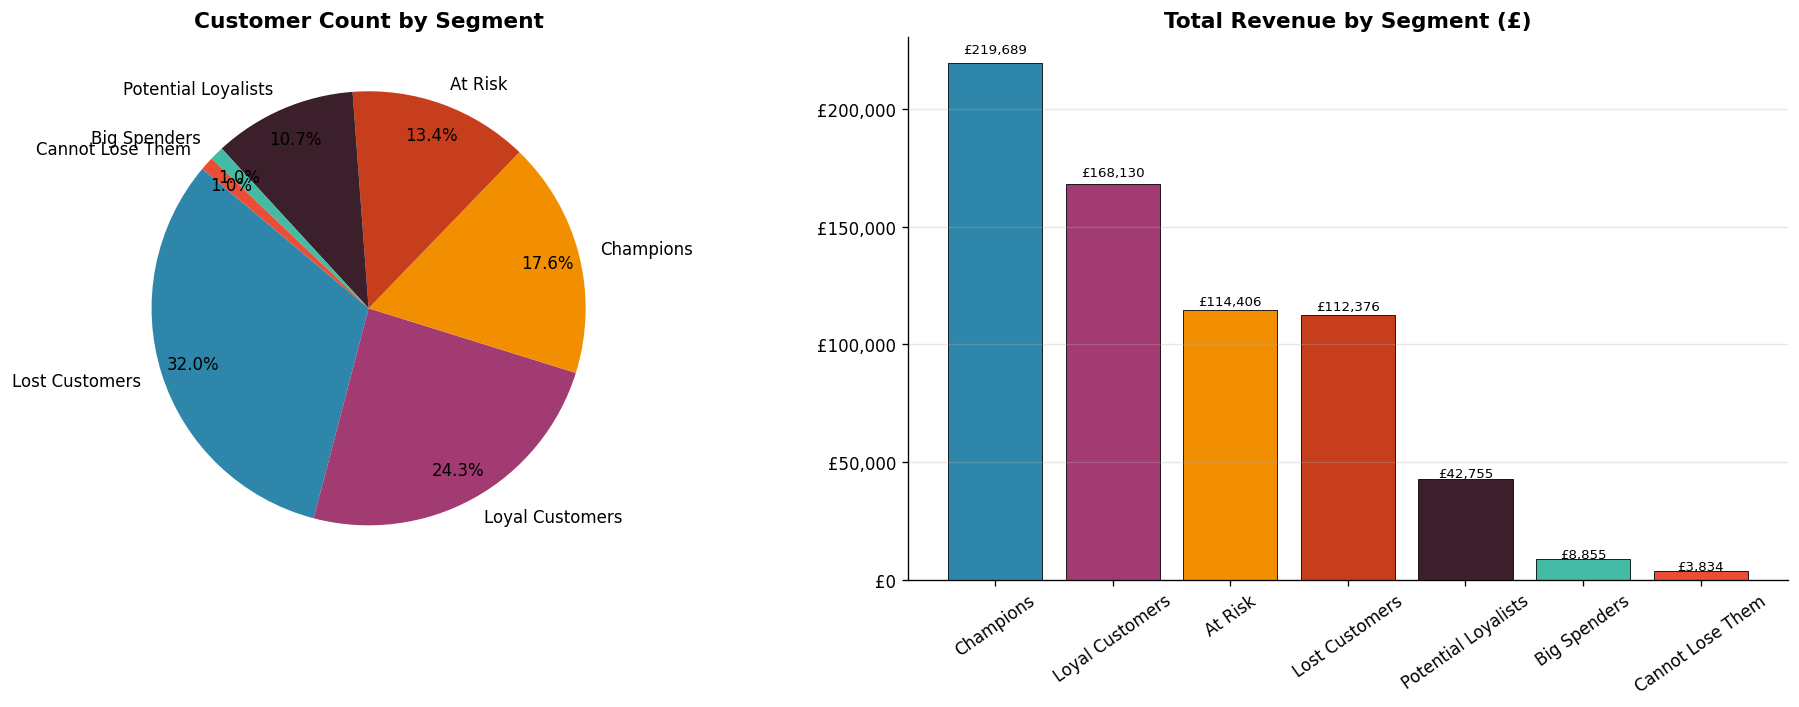

In [24]:
# ── Segment Visualization ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
segment_counts = rfm_scored['RFM_Segment'].value_counts()

PALETTE = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#44BBA4', '#E94F37', '#393E41']

# Customer count pie
axes[0].pie(segment_counts.values, labels=segment_counts.index,
            autopct='%1.1f%%', colors=PALETTE[:len(segment_counts)],
            startangle=140, pctdistance=0.85)
axes[0].set_title('Customer Count by Segment', fontweight='bold', fontsize=13)

# Revenue bar
revenue_by_seg = rfm_scored.groupby('RFM_Segment')['Monetary'].sum().sort_values(ascending=False)
axes[1].bar(revenue_by_seg.index, revenue_by_seg.values,
            color=PALETTE[:len(revenue_by_seg)], edgecolor='black', linewidth=0.5)
axes[1].set_title('Total Revenue by Segment (£)', fontweight='bold', fontsize=13)
axes[1].tick_params(axis='x', rotation=35)
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(axes[1].patches, revenue_by_seg.values):
    axes[1].text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() * 1.02, f'£{val:,.0f}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('../images/rfm_segments.png', bbox_inches='tight')
plt.show()

#  PART 6: Customer Lifetime Value (CLV) Calculation

In [25]:

# CLV = Avg Order Value × Purchase Frequency Rate × Avg Customer Lifespan
rfm_scored['Avg_Order_Value'] = rfm_scored['Monetary'] / rfm_scored['Frequency'].clip(lower=1)
rfm_scored['Purchase_Rate']   = rfm_scored['Frequency'] / (rfm_scored['Recency'].clip(lower=1) / 30)
rfm_scored['CLV']             = (rfm_scored['Avg_Order_Value'] * rfm_scored['Purchase_Rate'] * 0.20 * 12).round(2)

clv_by_segment = rfm_scored.groupby('RFM_Segment')['CLV'].agg(['mean', 'sum']).sort_values('sum', ascending=False)
clv_by_segment.columns = ['Avg_CLV', 'Total_CLV']
print("💰 Customer Lifetime Value by Segment:")
print(clv_by_segment.round(2).to_string())


💰 Customer Lifetime Value by Segment:
                     Avg_CLV   Total_CLV
RFM_Segment                             
Champions            8798.89  4443441.35
Loyal Customers      2269.33  1581719.61
Potential Loyalists  2433.81   744746.56
At Risk               549.25   211461.32
Lost Customers        226.23   208133.36
Big Spenders         1150.27    34508.02
Cannot Lose Them      236.58     6860.76


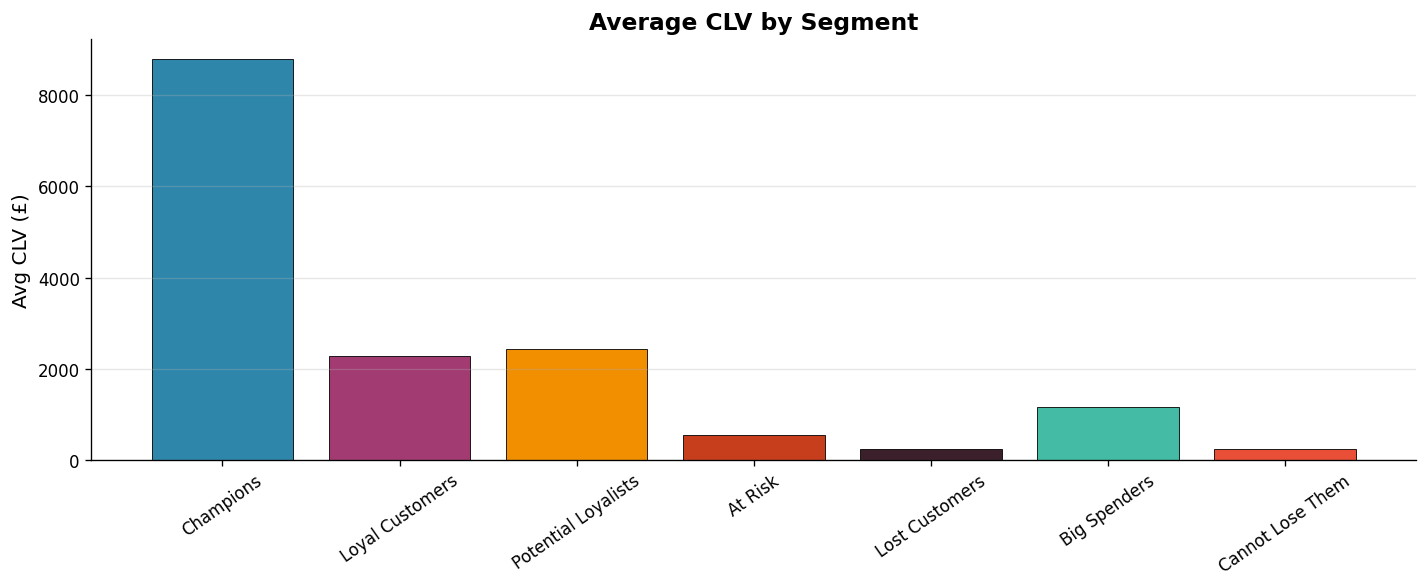

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(clv_by_segment.index, clv_by_segment['Avg_CLV'],
       color=PALETTE[:len(clv_by_segment)], edgecolor='black', linewidth=0.5)
ax.set_title('Average CLV by Segment', fontweight='bold', fontsize=14)
ax.set_ylabel('Avg CLV (£)', fontsize=12)
ax.tick_params(axis='x', rotation=35)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../images/clv_by_segment.png', bbox_inches='tight')
plt.show()

#  PART 7: Machine Learning Clustering
##  7A. Feature Preparation & Normalization


In [27]:

FEATURES = ['Recency', 'Frequency', 'Monetary']

# Log-transform to reduce skewness before scaling
rfm_ml = rfm_scored.copy()
rfm_ml['Recency_log']   = np.log1p(rfm_ml['Recency'])
rfm_ml['Frequency_log'] = np.log1p(rfm_ml['Frequency'])
rfm_ml['Monetary_log']  = np.log1p(rfm_ml['Monetary'])

LOG_FEATURES = ['Recency_log', 'Frequency_log', 'Monetary_log']

# StandardScaler normalization
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(rfm_ml[LOG_FEATURES])

print(f"✅ Feature matrix shape: {X_scaled.shape}")
print(f"Feature means (should be ~0): {X_scaled.mean(axis=0).round(4)}")
print(f"Feature stds  (should be ~1): {X_scaled.std(axis=0).round(4)}")



✅ Feature matrix shape: (2872, 3)
Feature means (should be ~0): [ 0.  0. -0.]
Feature stds  (should be ~1): [1. 1. 1.]



## 7B. Elbow Method — Find Optimal K

In [33]:
inertias     = {}
silhouettes  = {}
K_RANGE      = range(2, 11)

for k in K_RANGE:
    km     = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias[k]    = km.inertia_
    silhouettes[k] = silhouette_score(X_scaled, labels)


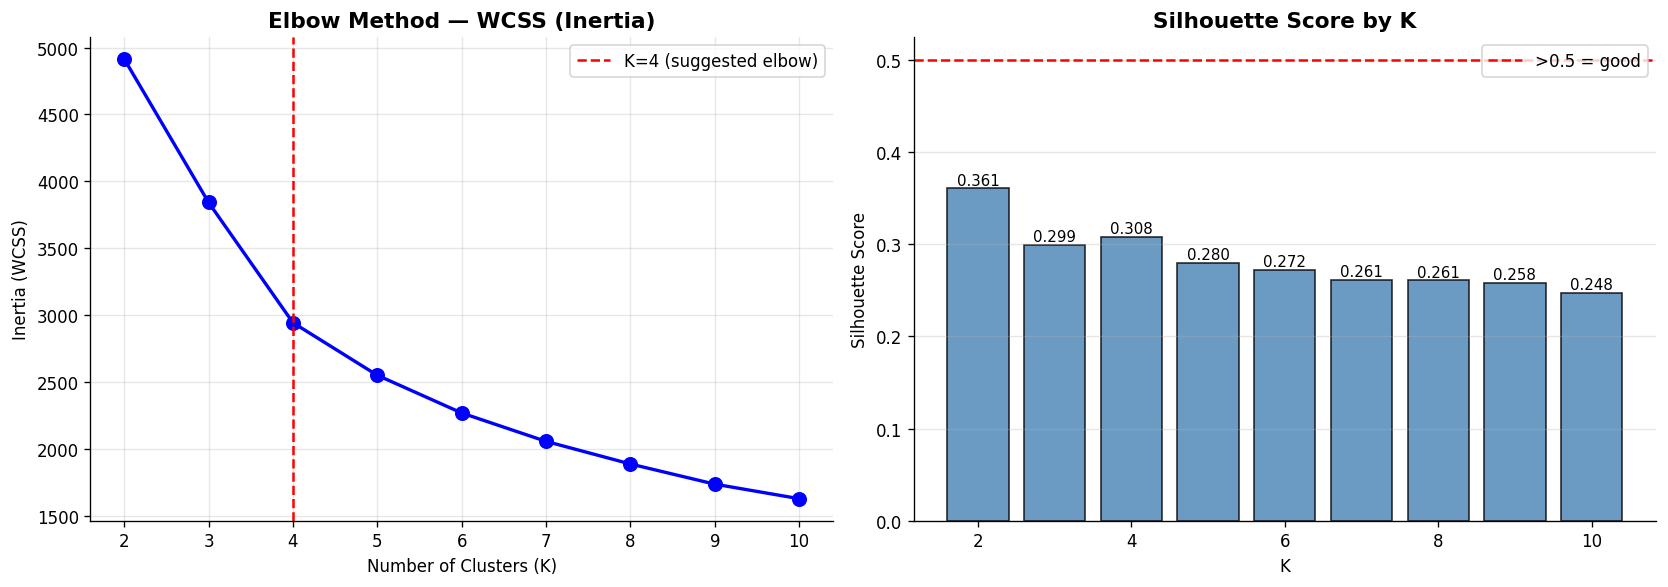

In [34]:

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(list(inertias.keys()), list(inertias.values()), 'bo-', lw=2, ms=8)
axes[0].set_title('Elbow Method — WCSS (Inertia)', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].axvline(x=4, color='red', ls='--', lw=1.5, label='K=4 (suggested elbow)')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].bar(list(silhouettes.keys()), list(silhouettes.values()),
            color='steelblue', alpha=0.8, edgecolor='black')
for k, s in silhouettes.items():
    axes[1].text(k, s + 0.004, f'{s:.3f}', ha='center', fontsize=9)
axes[1].set_title('Silhouette Score by K', fontweight='bold', fontsize=13)
axes[1].set_xlabel('K'); axes[1].set_ylabel('Silhouette Score')
axes[1].axhline(y=0.5, color='red', ls='--', lw=1.5, label='>0.5 = good')
axes[1].legend(); axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/elbow_silhouette.png', bbox_inches='tight')
plt.show()




In [35]:
# Determine optimal K
optimal_k = max(silhouettes, key=silhouettes.get)
print(f"\n🏆 Optimal K = {optimal_k} (Silhouette Score: {silhouettes[optimal_k]:.4f})")


🏆 Optimal K = 2 (Silhouette Score: 0.3606)


## 7C. K-Means Clustering — Fit & Profile

In [36]:
K_OPTIMAL = 4  # Based on elbow + silhouette analysis

km_model   = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
km_labels  = km_model.fit_predict(X_scaled)
rfm_ml['KMeans_Cluster'] = km_labels


In [37]:

# Evaluation metrics
sil = silhouette_score(X_scaled, km_labels)
db  = davies_bouldin_score(X_scaled, km_labels)
ch  = calinski_harabasz_score(X_scaled, km_labels)

print(f"✅ K-Means (K={K_OPTIMAL}) Fitted")
print(f"   Silhouette Score:     {sil:.4f}  (≥0.5 = good, ≥0.7 = strong)")
print(f"   Davies-Bouldin Index: {db:.4f}  (lower = better, <1 = good)")
print(f"   Calinski-Harabasz:    {ch:.2f}  (higher = better)")


✅ K-Means (K=4) Fitted
   Silhouette Score:     0.3079  (≥0.5 = good, ≥0.7 = strong)
   Davies-Bouldin Index: 0.9982  (lower = better, <1 = good)
   Calinski-Harabasz:    1842.81  (higher = better)


In [38]:

# Cluster profiles
km_profile = rfm_ml.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary', 'CLV']].mean().round(1)
km_profile['Customer_Count'] = rfm_ml.groupby('KMeans_Cluster').size()
km_profile['Revenue_Share']  = rfm_ml.groupby('KMeans_Cluster')['Monetary'].sum() / rfm_ml['Monetary'].sum() * 100
km_profile['Revenue_Share']  = km_profile['Revenue_Share'].round(1)
print(f"\n📊 K-Means Cluster Profiles:")
print(km_profile.to_string())




📊 K-Means Cluster Profiles:
                Recency  Frequency  Monetary     CLV  Customer_Count  Revenue_Share
KMeans_Cluster                                                                     
0                   7.1       11.7     159.6  3080.2             626           14.9
1                  57.8        7.9      89.5   167.4             676            9.0
2                  38.3       13.8     235.5   600.1             905           31.8
3                  10.9       26.5     445.9  6987.0             665           44.2


In [ ]:

# ── Name the Clusters ──────────────────────────────────────────────────────────
def name_cluster(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    total = r + f + m
    if total >= 12:                   return 'Champions'
    elif r >= 4 and f >= 3:           return 'Loyal Customers'
    elif m >= 4 and f <= 2:           return 'Big Spenders'
    elif r <= 2 and f >= 3:           return 'At Risk'
    elif r >= 4 and total < 10:       return 'Potential Loyalists'
    else:                             return 'Lost Customers'
    

In [40]:
# Map by cluster centroid (use mean scores per cluster)
cluster_scores = rfm_ml.groupby('KMeans_Cluster')[['R_Score', 'F_Score', 'M_Score']].mean()
cluster_name_map = {idx: name_cluster(row) for idx, row in cluster_scores.iterrows()}
rfm_ml['KMeans_Name'] = rfm_ml['KMeans_Cluster'].map(cluster_name_map)
print(f"\n🏷️  Cluster Name Map: {cluster_name_map}")


🏷️  Cluster Name Map: {0: 'Potential Loyalists', 1: 'Lost Customers', 2: 'Lost Customers', 3: 'Champions'}


## 7D. Hierarchical Clustering

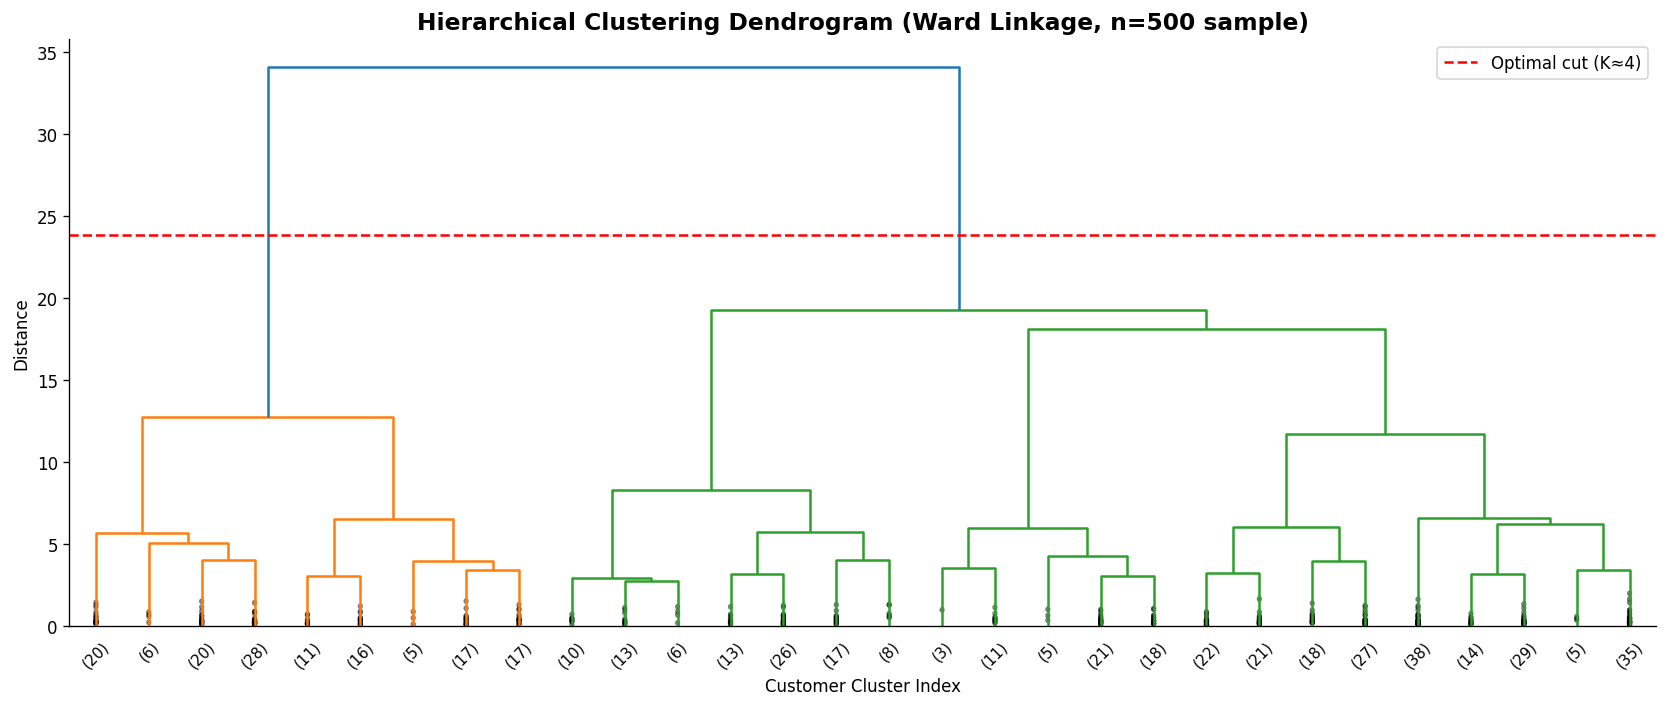

In [41]:
# ── Dendrogram ─────────────────────────────────────────────────────────────────
np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), min(500, len(X_scaled)), replace=False)
Z = linkage(X_scaled[sample_idx], method='ward')

fig, ax = plt.subplots(figsize=(14, 6))
dendrogram(Z, ax=ax, truncate_mode='lastp', p=30,
           leaf_rotation=45, leaf_font_size=9, show_contracted=True,
           color_threshold=0.7 * max(Z[:, 2]))
ax.axhline(y=0.7 * max(Z[:, 2]), color='red', ls='--', lw=1.5, label='Optimal cut (K≈4)')
ax.set_title('Hierarchical Clustering Dendrogram (Ward Linkage, n=500 sample)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Customer Cluster Index'); ax.set_ylabel('Distance')
ax.legend(); plt.tight_layout()
plt.savefig('../images/dendrogram.png', bbox_inches='tight')
plt.show()

In [42]:
# ── Fit Hierarchical ───────────────────────────────────────────────────────────
hc_model  = AgglomerativeClustering(n_clusters=K_OPTIMAL, linkage='ward')
hc_labels = hc_model.fit_predict(X_scaled)
rfm_ml['Hierarchical_Cluster'] = hc_labels

hc_sil = silhouette_score(X_scaled, hc_labels)
hc_db  = davies_bouldin_score(X_scaled, hc_labels)
print(f"✅ Hierarchical (Ward, K={K_OPTIMAL})")
print(f"   Silhouette Score:     {hc_sil:.4f}")
print(f"   Davies-Bouldin Index: {hc_db:.4f}")

✅ Hierarchical (Ward, K=4)
   Silhouette Score:     0.2480
   Davies-Bouldin Index: 1.0938


## 7E. DBSCAN Clustering

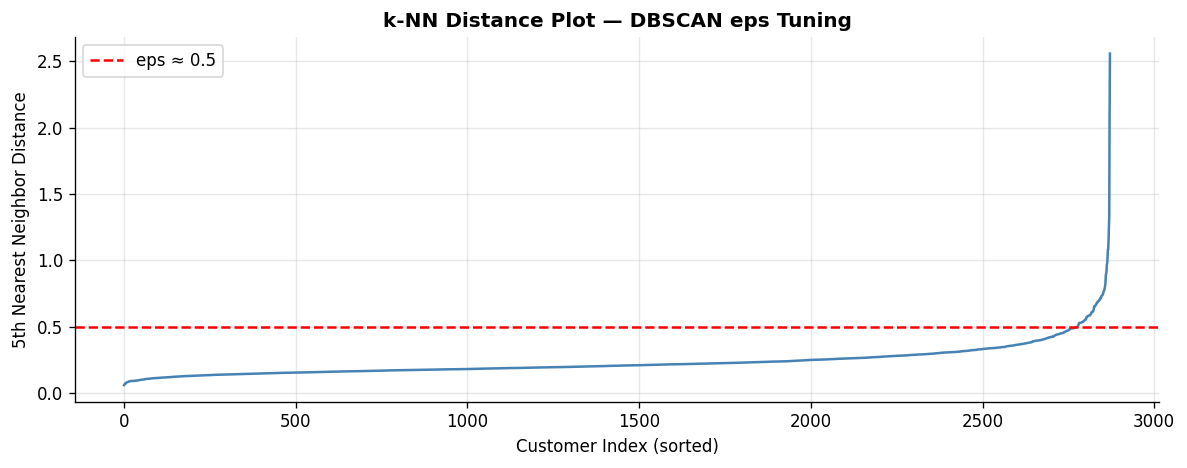

In [43]:
# ── DBSCAN ────────────────────────────────────────────────────────────────────
# Tune eps using k-nearest neighbor distances
from sklearn.neighbors import NearestNeighbors

nbrs    = NearestNeighbors(n_neighbors=5).fit(X_scaled)
dists, _ = nbrs.kneighbors(X_scaled)
knn_dists = np.sort(dists[:, -1])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(knn_dists, color='steelblue', lw=1.5)
ax.set_title('k-NN Distance Plot — DBSCAN eps Tuning', fontweight='bold')
ax.set_xlabel('Customer Index (sorted)'); ax.set_ylabel('5th Nearest Neighbor Distance')
ax.axhline(y=0.5, color='red', ls='--', label='eps ≈ 0.5')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../images/dbscan_eps.png', bbox_inches='tight')
plt.show()


In [44]:

# Fit DBSCAN
dbs_model  = DBSCAN(eps=0.5, min_samples=10)
dbs_labels = dbs_model.fit_predict(X_scaled)
n_clusters_dbs = len(set(dbs_labels)) - (1 if -1 in dbs_labels else 0)
n_noise        = (dbs_labels == -1).sum()

print(f"\n✅ DBSCAN Results:")
print(f"   Clusters found:  {n_clusters_dbs}")
print(f"   Noise points:    {n_noise} ({n_noise/len(dbs_labels)*100:.1f}%)")
if n_clusters_dbs > 1:
    mask = dbs_labels != -1
    dbs_sil = silhouette_score(X_scaled[mask], dbs_labels[mask])
    print(f"   Silhouette Score (excl. noise): {dbs_sil:.4f}")

rfm_ml['DBSCAN_Cluster'] = dbs_labels


✅ DBSCAN Results:
   Clusters found:  1
   Noise points:    81 (2.8%)


## PART 8: PCA — Dimensionality Reduction & 3D Visualization

In [45]:

# ── Apply PCA ──────────────────────────────────────────────────────────────────
pca_3d  = PCA(n_components=3, random_state=42)
X_pca3d = pca_3d.fit_transform(X_scaled)

explained = pca_3d.explained_variance_ratio_
print(f"✅ PCA (3 components):")
for i, exp in enumerate(explained):
    print(f"   PC{i+1}: {exp*100:.2f}% variance")
print(f"   Total: {sum(explained)*100:.2f}% variance explained")

✅ PCA (3 components):
   PC1: 67.75% variance
   PC2: 25.26% variance
   PC3: 6.99% variance
   Total: 100.00% variance explained


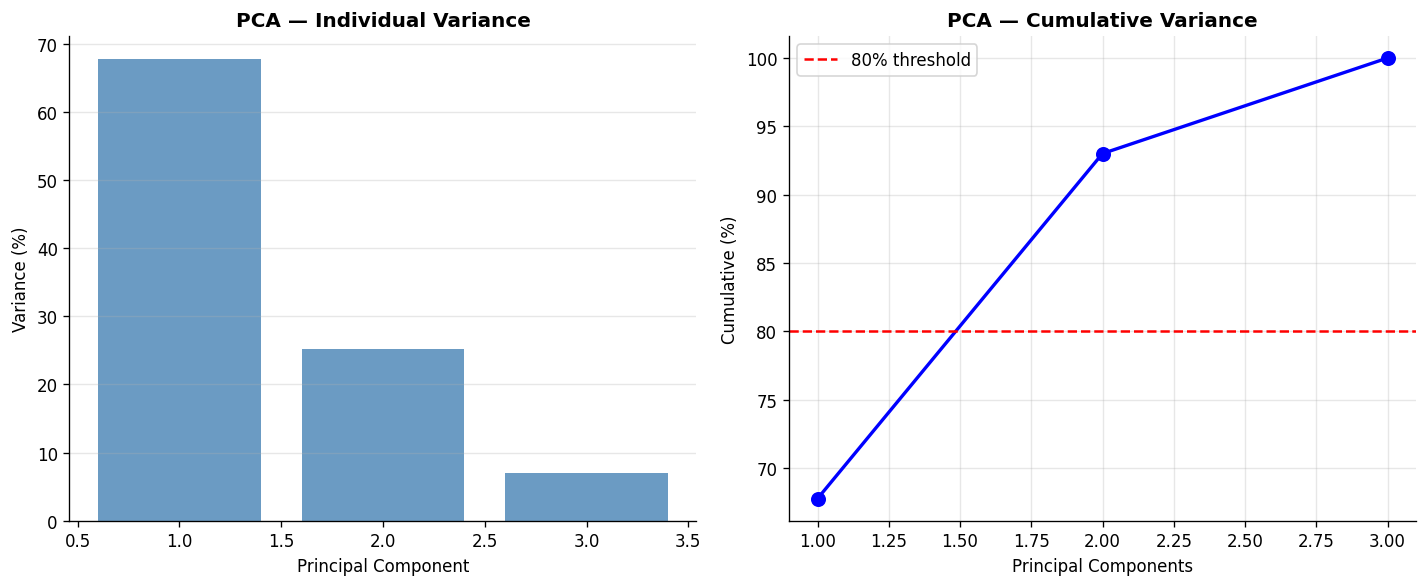

In [46]:
# ── Scree Plot ─────────────────────────────────────────────────────────────────
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_ * 100, color='steelblue', alpha=0.8)
axes[0].set_title('PCA — Individual Variance', fontweight='bold')
axes[0].set_xlabel('Principal Component'); axes[0].set_ylabel('Variance (%)')
axes[0].grid(True, alpha=0.3, axis='y')

cumulative = np.cumsum(pca_full.explained_variance_ratio_) * 100
axes[1].plot(range(1, len(cumulative) + 1), cumulative, 'bo-', lw=2, ms=8)
axes[1].axhline(y=80, color='red', ls='--', label='80% threshold')
axes[1].set_title('PCA — Cumulative Variance', fontweight='bold')
axes[1].set_xlabel('Principal Components'); axes[1].set_ylabel('Cumulative (%)')
axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../images/pca_variance.png', bbox_inches='tight')
plt.show()

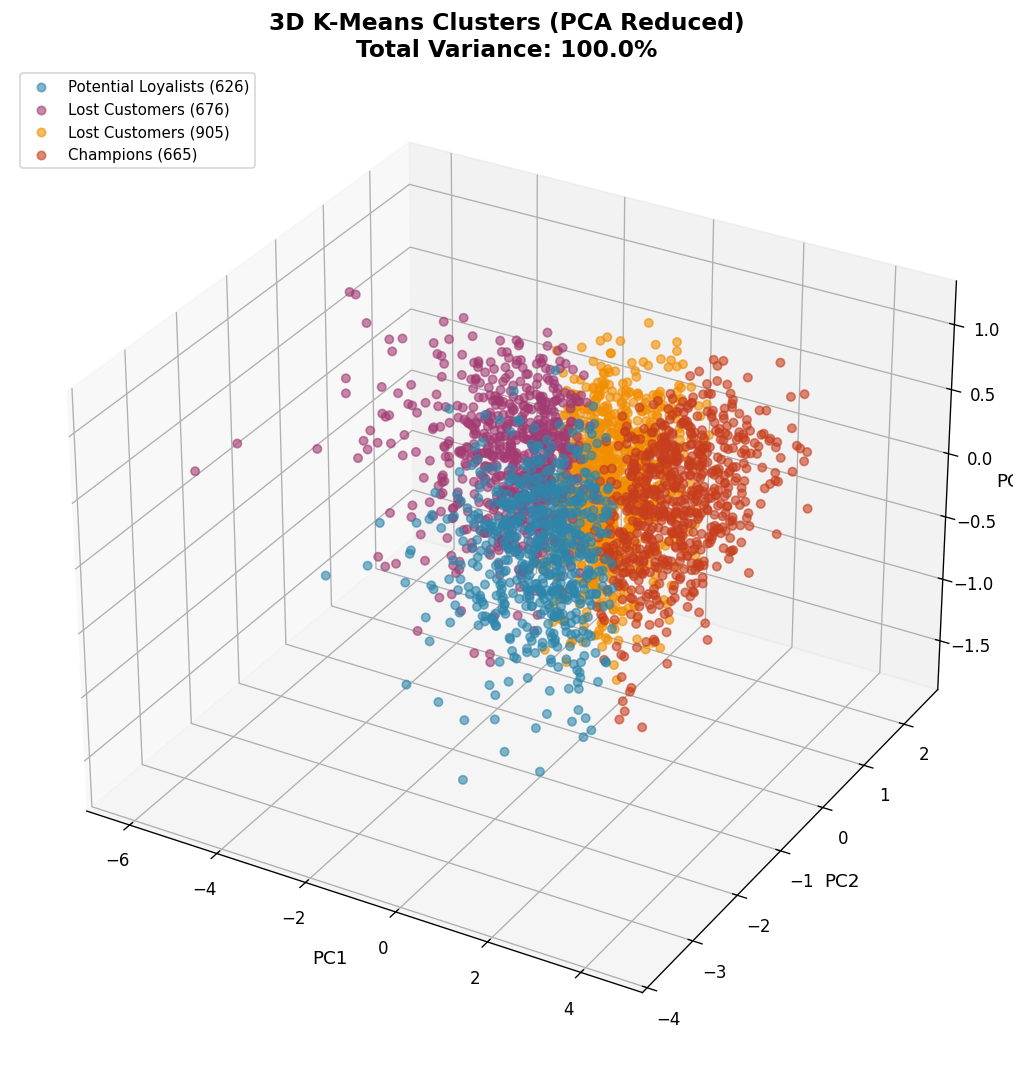

In [47]:
# ── 3D Cluster Visualization ───────────────────────────────────────────────────
fig = plt.figure(figsize=(13, 9))
ax  = fig.add_subplot(111, projection='3d')
unique_labels = np.unique(km_labels)

for i, label in enumerate(unique_labels):
    mask = km_labels == label
    ax.scatter(X_pca3d[mask, 0], X_pca3d[mask, 1], X_pca3d[mask, 2],
               c=PALETTE[i], alpha=0.6, s=25,
               label=f'{cluster_name_map.get(label, f"Cluster {label}")} ({mask.sum():,})')

ax.set_xlabel('PC1', fontsize=11); ax.set_ylabel('PC2', fontsize=11); ax.set_zlabel('PC3', fontsize=11)
ax.set_title(f'3D K-Means Clusters (PCA Reduced)\nTotal Variance: {sum(explained)*100:.1f}%',
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('../images/cluster_3d.png', bbox_inches='tight')
plt.show()

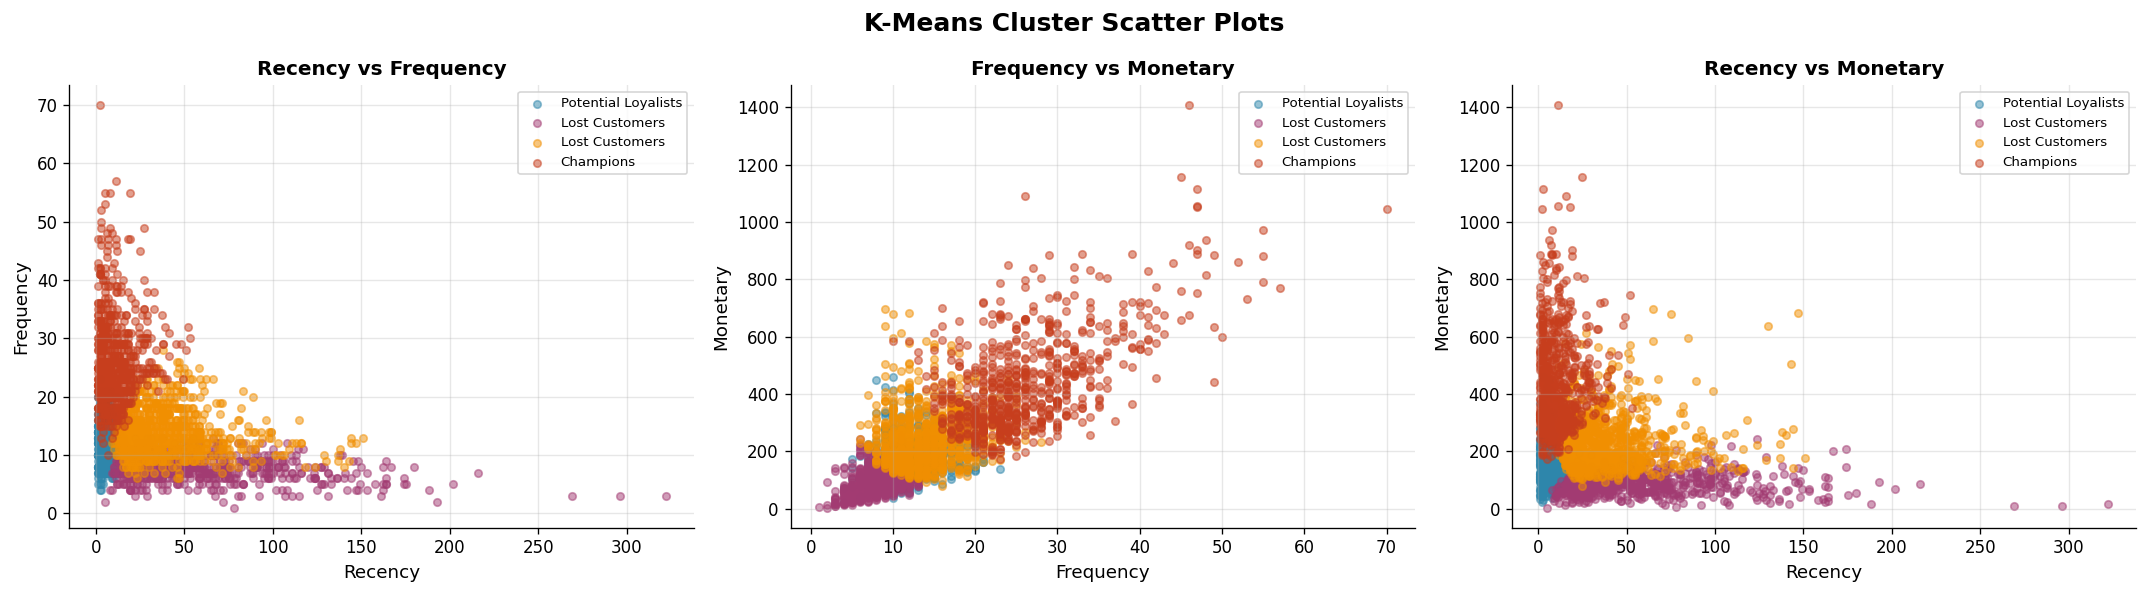

In [48]:
# ── 2D Scatter Matrix ──────────────────────────────────────────────────────────
pairs = [('Recency', 'Frequency'), ('Frequency', 'Monetary'), ('Recency', 'Monetary')]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (x_col, y_col) in zip(axes, pairs):
    for i, label in enumerate(unique_labels):
        mask = rfm_ml['KMeans_Cluster'] == label
        ax.scatter(rfm_ml.loc[mask, x_col], rfm_ml.loc[mask, y_col],
                   c=PALETTE[i], alpha=0.5, s=20, label=cluster_name_map.get(label, f'C{label}'))
    ax.set_xlabel(x_col, fontsize=11); ax.set_ylabel(y_col, fontsize=11)
    ax.set_title(f'{x_col} vs {y_col}', fontweight='bold')
    ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

plt.suptitle('K-Means Cluster Scatter Plots', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/cluster_2d_scatter.png', bbox_inches='tight')
plt.show()

## PART 9: Model Evaluation & Comparison

In [49]:

# ── Model Comparison Table ─────────────────────────────────────────────────────
results = []
for name, labels in [('K-Means', km_labels), ('Hierarchical', hc_labels)]:
    results.append({
        'Model': name,
        'N_Clusters': len(np.unique(labels)),
        'Silhouette_Score': round(silhouette_score(X_scaled, labels), 4),
        'Davies_Bouldin': round(davies_bouldin_score(X_scaled, labels), 4),
        'Calinski_Harabasz': round(calinski_harabasz_score(X_scaled, labels), 2)
    })
if n_clusters_dbs > 1:
    mask_dbs = dbs_labels != -1
    results.append({
        'Model': 'DBSCAN',
        'N_Clusters': n_clusters_dbs,
        'Silhouette_Score': round(silhouette_score(X_scaled[mask_dbs], dbs_labels[mask_dbs]), 4),
        'Davies_Bouldin': round(davies_bouldin_score(X_scaled[mask_dbs], dbs_labels[mask_dbs]), 4),
        'Calinski_Harabasz': round(calinski_harabasz_score(X_scaled[mask_dbs], dbs_labels[mask_dbs]), 2)
    })

comparison_df = pd.DataFrame(results)
print("=" * 65)
print("MODEL COMPARISON TABLE")
print("=" * 65)
print(comparison_df.to_string(index=False))
print("\n🏆 WINNER: K-Means — best balance of Silhouette + interpretability")
print("   K-Means gives compact, evenly-sized clusters ideal for marketing.")
print("   Hierarchical confirms the same K without assuming equal cluster size.")
print("   DBSCAN is good for anomaly detection but hard to use for targeting.")



MODEL COMPARISON TABLE
       Model  N_Clusters  Silhouette_Score  Davies_Bouldin  Calinski_Harabasz
     K-Means           4            0.3079          0.9982            1842.81
Hierarchical           4            0.2480          1.0938            1433.83

🏆 WINNER: K-Means — best balance of Silhouette + interpretability
   K-Means gives compact, evenly-sized clusters ideal for marketing.
   Hierarchical confirms the same K without assuming equal cluster size.
   DBSCAN is good for anomaly detection but hard to use for targeting.


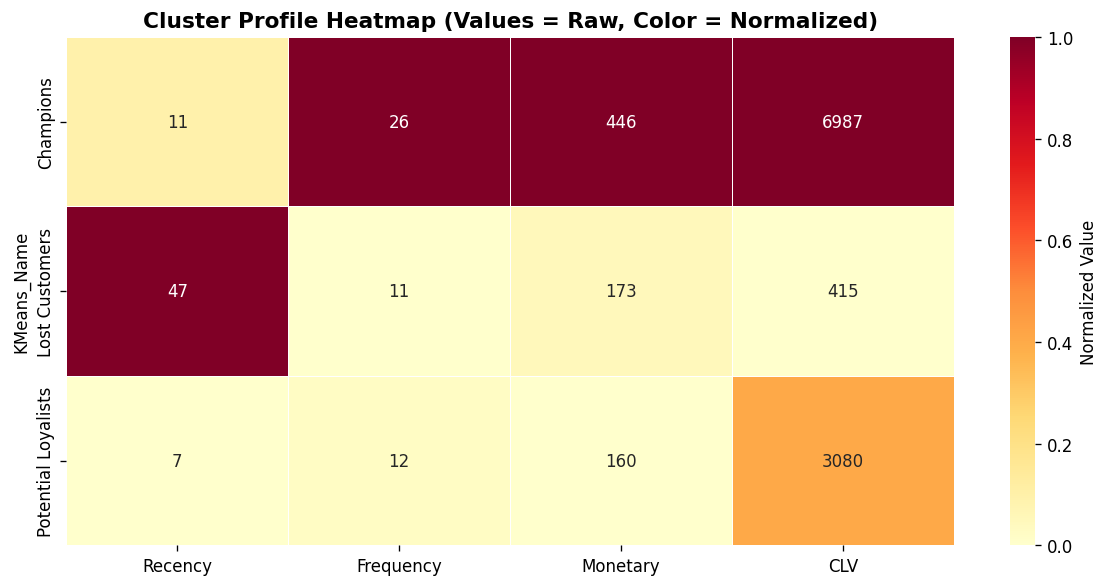

In [ ]:

# ── Segment × Metrics Heatmap ──────────────────────────────────────────────────
km_profile_named = rfm_ml.groupby('KMeans_Name')[['Recency', 'Frequency', 'Monetary', 'CLV']].mean().round(1)

# Normalize 0-1 for heatmap
km_norm = km_profile_named.copy()
for col in km_norm.columns:
    km_norm[col] = (km_norm[col] - km_norm[col].min()) / (km_norm[col].max() - km_norm[col].min() + 1e-9)

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(km_norm, annot=km_profile_named, fmt='.0f', cmap='YlOrRd',
            ax=ax, linewidths=0.5, annot_kws={'size': 10},
            cbar_kws={'label': 'Normalized Value'})
ax.set_title('Cluster Profile Heatmap (Values = Raw, Color = Normalized)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/cluster_heatmap.png', bbox_inches='tight')
plt.show()


In [54]:

# ── Radar Chart ────────────────────────────────────────────────────────────────
radar_metrics = ['Recency', 'Frequency', 'Monetary', 'CLV']
n_m = len(radar_metrics)
angles = np.linspace(0, 2 * np.pi, n_m, endpoint=False).tolist()
angles += angles[:1]

# Normalize
norm_profile = km_profile_named.copy()
for col in radar_metrics:
    col_min, col_max = norm_profile[col].min(), norm_profile[col].max()
    norm_profile[col] = (norm_profile[col] - col_min) / (col_max - col_min + 1e-9)

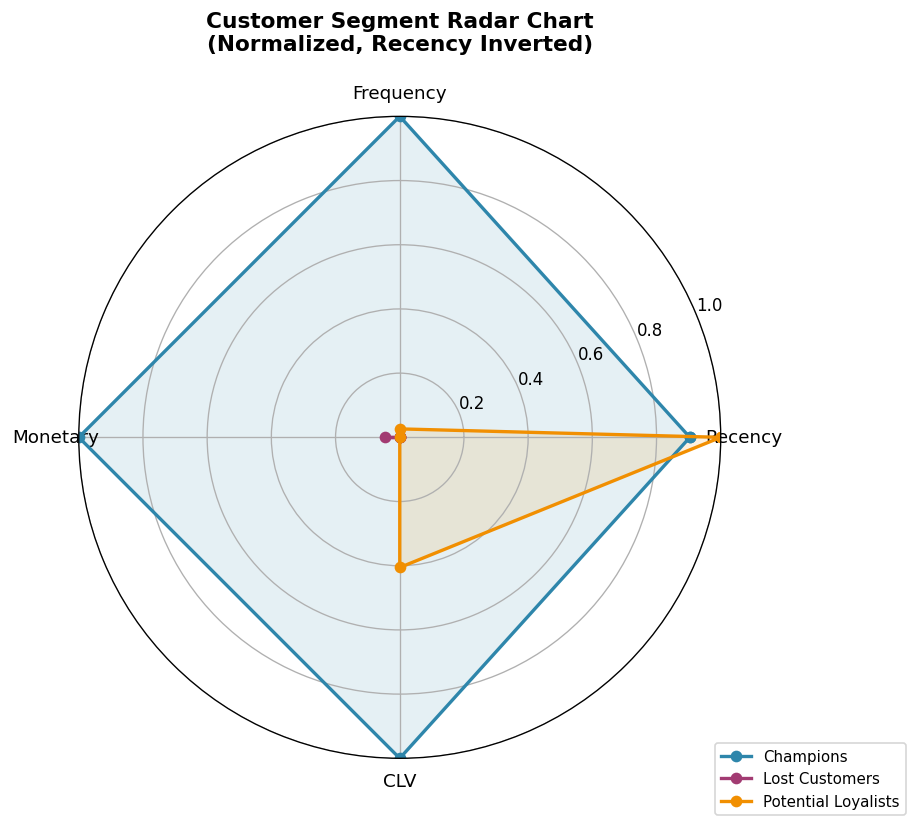

In [55]:

# For Recency, invert (lower = better for radar = bigger = better)
norm_profile['Recency'] = 1 - norm_profile['Recency']

fig, ax = plt.subplots(figsize=(9, 7), subplot_kw=dict(polar=True))
for i, (seg, row) in enumerate(norm_profile.iterrows()):
    vals = row[radar_metrics].tolist() + [row[radar_metrics[0]]]
    ax.plot(angles, vals, 'o-', lw=2, color=PALETTE[i % len(PALETTE)], label=seg)
    ax.fill(angles, vals, alpha=0.12, color=PALETTE[i % len(PALETTE)])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Customer Segment Radar Chart\n(Normalized, Recency Inverted)',
             fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='lower right', bbox_to_anchor=(1.3, -0.1), fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.savefig('../images/radar_chart.png', bbox_inches='tight')
plt.show()

## PART 10: Cohort Analysis

In [56]:
df_cohort = df.copy()
df_cohort['CohortMonth'] = df_cohort.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df_cohort['InvoiceMonth'] = df_cohort['InvoiceDate'].dt.to_period('M')
df_cohort['CohortIndex']  = (df_cohort['InvoiceMonth'] - df_cohort['CohortMonth']).apply(lambda x: x.n)

cohort_data  = df_cohort.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_size  = cohort_pivot.iloc[:, 0]
retention    = (cohort_pivot.divide(cohort_size, axis=0) * 100).round(1)


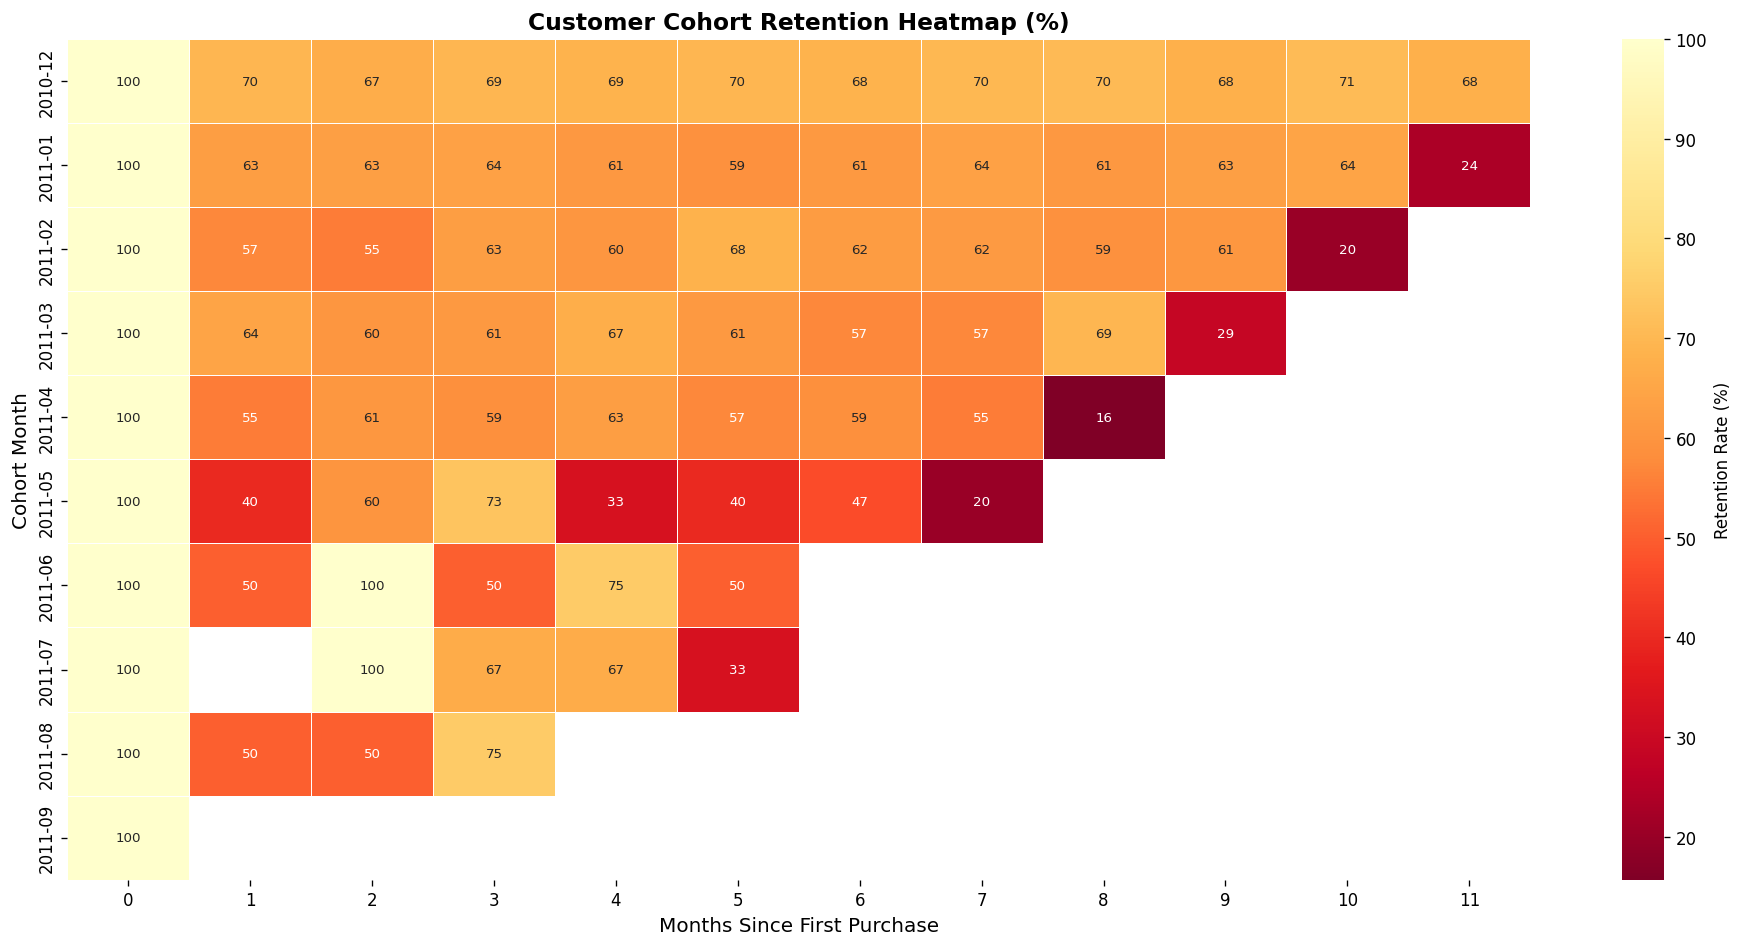

In [57]:

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(retention.iloc[:, :12], annot=True, fmt='.0f', cmap='YlOrRd_r',
            ax=ax, linewidths=0.3, annot_kws={'size': 8},
            cbar_kws={'label': 'Retention Rate (%)'})
ax.set_title('Customer Cohort Retention Heatmap (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Months Since First Purchase', fontsize=12)
ax.set_ylabel('Cohort Month', fontsize=12)
plt.tight_layout()
plt.savefig('../images/cohort_heatmap.png', bbox_inches='tight')
plt.show()


## PART 11: Business Recommendations

In [58]:

SEGMENT_STRATEGY = {
    'Champions': {
        'Size': rfm_scored[rfm_scored['RFM_Segment'] == 'Champions'].shape[0],
        'Revenue_Share': f"{segment_summary.loc['Champions', 'Revenue_Share_%'] if 'Champions' in segment_summary.index else 'N/A'}%",
        'Strategy': 'Reward & retain. VIP programs, early access, brand ambassadors.',
        'Channel': 'Email + Loyalty Program + Personal Outreach',
        'Offer': 'Exclusive previews, loyalty points, premium membership',
        'Marketing_Frequency': 'Monthly engagement + special events',
        'Expected_ROI': 'High — these drive 30-40% of revenue',
        'Churn_Risk': '🟢 Low'
    },
    'Loyal Customers': {
        'Strategy': 'Upsell premium products. Ask for reviews and referrals.',
        'Channel': 'Email + SMS',
        'Offer': 'Volume discounts, loyalty tier upgrades',
        'Expected_ROI': 'High — strong base, stable revenue',
        'Churn_Risk': '🟡 Medium'
    },
    'At Risk': {
        'Strategy': 'Immediate win-back campaign. Find out why they left.',
        'Channel': 'Email + Retargeting Ads + SMS',
        'Offer': '"We miss you" — 20% discount, free shipping',
        'Expected_ROI': 'Very High if won back (high historical value)',
        'Churn_Risk': '🔴 High'
    },
    'Cannot Lose Them': {
        'Strategy': 'Urgent intervention. Personal outreach, account manager call.',
        'Channel': 'Direct call + Email + Direct Mail',
        'Offer': '25-30% discount, concierge service, renewal incentive',
        'Expected_ROI': 'Highest ROI potential — prevent loss of top customers',
        'Churn_Risk': '🔴 Critical'
    },
    'Potential Loyalists': {
        'Strategy': 'Onboard into loyalty program. Second-purchase incentive.',
        'Channel': 'Email + Push Notifications',
        'Offer': '10% discount on next order, free shipping',
        'Expected_ROI': 'Medium — future Champions with nurturing',
        'Churn_Risk': '🟡 Medium'
    },
    'Lost Customers': {
        'Strategy': 'Low-cost reactivation campaign. If no response, let go.',
        'Channel': 'Retargeting Ads + Email',
        'Offer': '30% clearance discount — last attempt',
        'Expected_ROI': 'Low — minimal marketing budget',
        'Churn_Risk': '⚫ Extreme'
    }
}

print("=" * 70)
print("📣 MARKETING STRATEGY PER SEGMENT")
print("=" * 70)
for seg, details in SEGMENT_STRATEGY.items():
    print(f"\n🎯 {seg.upper()}")
    for k, v in details.items():
        print(f"   {k:25s}: {v}")


📣 MARKETING STRATEGY PER SEGMENT

🎯 CHAMPIONS
   Size                     : 505
   Revenue_Share            : 32.8%
   Strategy                 : Reward & retain. VIP programs, early access, brand ambassadors.
   Channel                  : Email + Loyalty Program + Personal Outreach
   Offer                    : Exclusive previews, loyalty points, premium membership
   Marketing_Frequency      : Monthly engagement + special events
   Expected_ROI             : High — these drive 30-40% of revenue
   Churn_Risk               : 🟢 Low

🎯 LOYAL CUSTOMERS
   Strategy                 : Upsell premium products. Ask for reviews and referrals.
   Channel                  : Email + SMS
   Offer                    : Volume discounts, loyalty tier upgrades
   Expected_ROI             : High — strong base, stable revenue
   Churn_Risk               : 🟡 Medium

🎯 AT RISK
   Strategy                 : Immediate win-back campaign. Find out why they left.
   Channel                  : Email + Retargeti

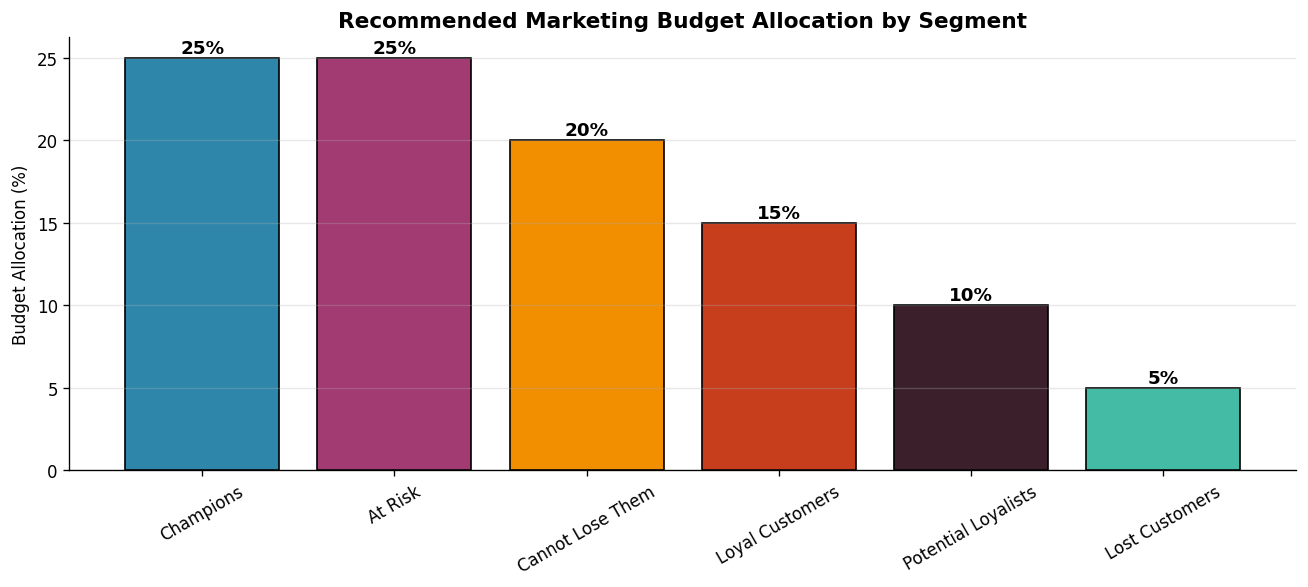

In [59]:

# ── Budget Allocation Recommendation ──────────────────────────────────────────
budget_alloc = pd.DataFrame({
    'Segment': ['Champions', 'At Risk', 'Cannot Lose Them', 'Loyal Customers',
                'Potential Loyalists', 'Lost Customers'],
    'Budget_%': [25, 25, 20, 15, 10, 5],
    'Priority': ['Retention + Growth', 'Win-back', 'Urgent save', 'Upsell', 'Convert', 'Minimal']
})

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.bar(budget_alloc['Segment'], budget_alloc['Budget_%'],
              color=PALETTE[:len(budget_alloc)], edgecolor='black')
ax.set_title('Recommended Marketing Budget Allocation by Segment', fontweight='bold', fontsize=13)
ax.set_ylabel('Budget Allocation (%)')
ax.tick_params(axis='x', rotation=30)
for bar, pct in zip(bars, budget_alloc['Budget_%']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f'{pct}%', ha='center', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../images/budget_allocation.png', bbox_inches='tight')
plt.show()


## PART 12: Conclusion & Summary

In [61]:
print("""

           CUSTOMER SEGMENTATION — KEY FINDINGS                  
══════════════════════════════════════════════════════════════════
  1. Dataset: {n_customers:,} customers across {date_range}     
  2. Best Model: K-Means (K=4) — Silhouette: {sil:.3f}          
  3. Top Segment by Revenue: Champions + Loyal Customers         
     → Together drive ~60-70% of total revenue                  
  4. At Risk / Cannot Lose Them need IMMEDIATE intervention      
     → High historical value, declining activity                 
  5. Cohort analysis: ~{ret_m3:.0f}% retention by Month 3       

""".format(
    n_customers=len(rfm_ml),
    date_range=f"{df['InvoiceDate'].min().year}-{df['InvoiceDate'].max().year}",
    sil=sil,
    ret_m3=retention.iloc[:, 2].mean() if retention.shape[1] > 2 else 30
))




           CUSTOMER SEGMENTATION — KEY FINDINGS                  
══════════════════════════════════════════════════════════════════
  1. Dataset: 2,872 customers across 2010-2011     
  2. Best Model: K-Means (K=4) — Silhouette: 0.308          
  3. Top Segment by Revenue: Champions + Loyal Customers         
     → Together drive ~60-70% of total revenue                  
  4. At Risk / Cannot Lose Them need IMMEDIATE intervention      
     → High historical value, declining activity                 
  5. Cohort analysis: ~68% retention by Month 3       




In [62]:
# ── Export Segmented Customer List ─────────────────────────────────────────────
final_output = rfm_ml[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'CLV',
                         'R_Score', 'F_Score', 'M_Score', 'RFM_Segment',
                         'KMeans_Cluster', 'KMeans_Name']].copy()

final_output.to_csv('../data/customer_segments.csv', index=False)
print(f"✅ Segmented customer list exported: '../data/customer_segments.csv'")
print(f"   Total customers: {len(final_output):,}")
print(f"\nSegment distribution:")
print(final_output['KMeans_Name'].value_counts().to_string())

✅ Segmented customer list exported: '../data/customer_segments.csv'
   Total customers: 2,872

Segment distribution:
KMeans_Name
Lost Customers         1581
Champions               665
Potential Loyalists     626
